In [17]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# which floor did wirtual reach?
wirtual1 = np.array([0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 2, 2, 1]) # until 1:01:20
wirtual2 = np.array([2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 0, 2]) # until 2:01:05
wirtual3 = np.array([0, 0, 2, 2, 1, 1, 1, 0, 2, 0, 0, 2, 1, 2, 2, 0, 0, 0, 2, 1, 2]) # until 3:00:14
wirtual4 = np.array([2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2]) # until 4:00:04
wirtual5 = np.array([2, 2, 2, 2, 2, 0, 1, 1, 2, 0, 2, 0, 2, 2]) # until 5:03:00
wirtual6 = np.array([2, 1, 3, 2, 3, 0, 2, 2, 2]) # until 6:10:43
wirtual7 = np.array([0, 1, 3, 2, 2, 2, 2, 1, 2, 0, 3]) # until 7:02:47
wirtual8 = np.array([2, 1, 2, 4, 3, 2]) # until 8:03:00
wirtual9 = np.array([2, 1, 2, 2, 2, 2, 4]) # until 9:00:09
wirtual10= np.array([1, 2, 1, 2, 0, 2, 1, 3, 2, 4, 2, 2]) # until 10:00:00
wirtual11= np.array([1, 2, 0, 1, 4, 2, 1, 2, 4, 4]) # until 11:07:01
wirtual12= np.array([4, 2, 2, 1, 0, 2, 2, 2, 2, 4]) # until 12:25:50
wirtual13= np.array([4, 1, 1, 2, 0]) # until 13:00:43
wirtual14= np.array([0, 0, 2, 4, 4, 2, 1, 2, 1, 2]) # until 14:00:20

wirtual = np.concatenate((wirtual1, wirtual2, wirtual3, wirtual4, wirtual5, wirtual6, wirtual7, wirtual8, wirtual9, wirtual10, wirtual11, wirtual12, wirtual13, wirtual14), axis=0)
floor = 2
wirtual_floor_success = np.sign(wirtual[wirtual >= floor] - floor)
sequence = wirtual_floor_success


In [30]:
window_size = 20

# Initialize the rolling average array
rolling_avg = np.zeros_like(sequence, dtype=float)

# Compute rolling average
for i in range(len(sequence)):
    if i < window_size - 1:
        # For the first few elements, average the elements from the start to the current position
        rolling_avg[i] = np.mean(sequence[:i+1])
    else:
        # For the rest, compute the average of the window
        rolling_avg[i] = np.mean(sequence[i-window_size+1:i+1])



In [33]:
# Probability model function
def prob_model(n, a, b, c):
    return np.minimum(a + n * b, c)

def logistic_curve(n, low, high, shift, speed):
    return low + (high-low) / (1 + np.exp(-speed * (n-shift)))

def loss_logistic(params, sequence):
    low, high, shift, speed = params
    n = np.arange(len(sequence))
    predicted_probs = logistic_curve(n, low, high, shift, speed)
    loss = np.mean((sequence - predicted_probs)**2)
    return np.sum(loss)

# Loss function to be minimized (Binary Cross Entropy)
def loss(params, sequence):
    a, b, c = params
    n = np.arange(len(sequence))
    predicted_probs = prob_model(n, a, b, c)
    # Binary cross-entropy loss
    loss = -(sequence * np.log(predicted_probs + 1e-9) + (1 - sequence) * np.log(1 - predicted_probs + 1e-9))
    return np.sum(loss)

# Initial guesses for parameters a, b, and c
initial_params = [0.1, 0.1, 0.9, 0.9]

# Bounds for a, b, and c
bounds = [(0, 1), (0, 1), (-100, 300), (0, 30)]

# Run the optimizer
result = minimize(loss_logistic, initial_params, args=(rolling_avg,), bounds=bounds, method='L-BFGS-B')

# Print the optimized parameters
if result.success:
    fitted_params = result.x
    print("Optimized parameters (low, high, shift, speed):", fitted_params)
else:
    print("Optimization failed:", result.message)


Optimized parameters (low, high, shift, speed): [ 0.          0.33087912 48.78192498  0.14232266]


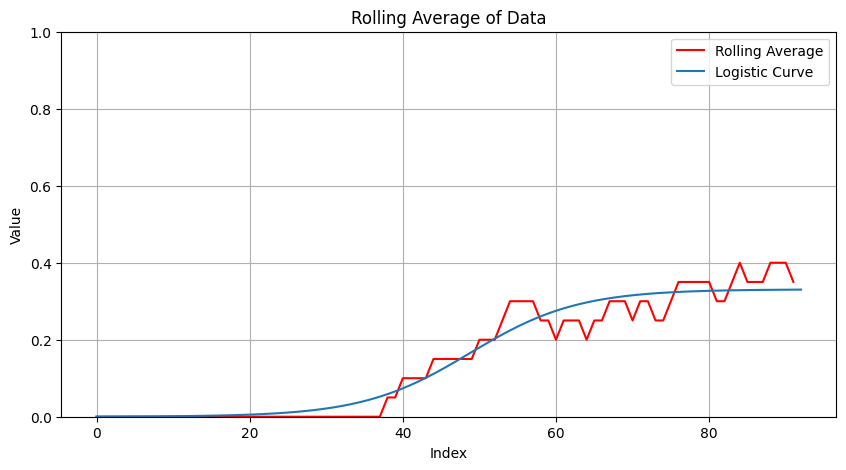

In [34]:
# Generate x values
x_values = np.linspace(0, len(sequence), 400)

low, high, shift, speed = fitted_params

# Calculate y values
y_values = logistic_curve(x_values, low, high, shift, speed)

# Plotting the result
plt.figure(figsize=(10, 5))
#plt.plot(sequence, label='Original Data')
plt.plot(rolling_avg, label='Rolling Average', color='red')
plt.plot(x_values, y_values, label='Logistic Curve')
plt.title('Rolling Average of Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()